In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import os

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

from scipy import optimize

from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

path_dades = "/content/gdrive/MyDrive/Colab Notebooks/postgrau/progecte/propi/dades/data/"

if os.path.exists(path_dades):
    print(f"Directory '{path_dades}' exists.")

ValueError: mount failed

In [ ]:
file_train = 'clean_train_data.csv'
file_train = 'data_clean_bo.csv'

data = pd.read_csv(path_dades + file_train, index_col="Time", parse_dates=True)

data.head(2)

Data is already **clean** and **time consistent**.

## Data Statistcs

In [ ]:
data.describe().transpose()

In [ ]:
# median by hours, training data
data.resample("h").median().plot(subplots=True, layout=(-1, 1), lw=1, figsize=(16, 8))
plt.show()

In [ ]:
data_int = data[['Conveyor Belt Feed Rate (t/h)', 'Power Draw (MW)', 'Dilution Flow Rate (m3/h)']]
sns.pairplot(data_int)
plt.show()

# Correlation matrix
corr_matrix = data_int.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [ ]:
fig = px.histogram(data, x='Conveyor Belt Feed Rate (t/h)', nbins=200, title='Histogram of Conveyor Belt Feed Rate (t/h)')

fig.update_layout(
    xaxis_title='Conveyor Belt Feed Rate (t/h)',
    yaxis_title='Number of Occurrences',
    bargap=0,  # Gap between bars
    template='plotly_white'  # Template for the plot style
)

# Show the plot
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In here I could normalize the data in a way to find how with the same Conveyor Belt Feed Rate (t/h) varies the correlance between the other 2 variables.
It's important that the correlation between **Dilution Flow Rate (m3/h)-Power Draw (MW) 0.88** it's **greater** than correlation between **Dilution Flow Rate (m3/h)-Conveyor Belt Feed Rate (t/h) 0.84**

**What it means?**

In [ ]:
filtered_df = data[data['Conveyor Belt Feed Rate (t/h)'] > 500]

# Bin the data
bins = np.linspace(filtered_df['Conveyor Belt Feed Rate (t/h)'].min(), filtered_df['Conveyor Belt Feed Rate (t/h)'].max(), 100)
filtered_df['binned'] = np.digitize(filtered_df['Conveyor Belt Feed Rate (t/h)'], bins)

# Aggregate the data
agg_df = filtered_df.groupby('binned').agg({
    'Conveyor Belt Feed Rate (t/h)': 'mean',
    'Power Draw (MW)': 'mean',
    'Dilution Flow Rate (m3/h)': 'mean'  # Adding the third variable
}).reset_index()

# Create an interactive 3D scatter plot
fig = px.scatter_3d(
    agg_df,
    x='Conveyor Belt Feed Rate (t/h)',
    z='Power Draw (MW)',
    y='Dilution Flow Rate (m3/h)',
    color='Dilution Flow Rate (m3/h)',
    labels={
        'Conveyor Belt Feed Rate (t/h)': 'Conveyor Belt Feed Rate (t/h)',
        'Power Draw (MW)': 'Power Draw (MW)',
        'Dilution Flow Rate (m3/h)': 'Dilution Flow Rate (m3/h)'
    },
    title='Aggregated Conveyor Belt Feed Rate vs Power Draw vs Dilution Flow Rate (Filtered Data)',
    color_continuous_scale='Viridis'
)

# Show the plot
fig.show()

<ipython-input-8-08222ace50be>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Select rows  where in column Conveyor Belt Feed Rate (t/h) value is 2590-2610
filtered_df = data[(data['Conveyor Belt Feed Rate (t/h)'] >= 2590) & (data['Conveyor Belt Feed Rate (t/h)'] <= 2610)]
print(len(filtered_df))
# Bin the data
bins = np.linspace(filtered_df['Conveyor Belt Feed Rate (t/h)'].min(), filtered_df['Conveyor Belt Feed Rate (t/h)'].max(), 300)
filtered_df['binned'] = np.digitize(filtered_df['Conveyor Belt Feed Rate (t/h)'], bins)

# Aggregate the data
agg_df = filtered_df.groupby('binned').agg({
    'Conveyor Belt Feed Rate (t/h)': 'mean',
    'Power Draw (MW)': 'mean',
    'Dilution Flow Rate (m3/h)': 'mean'  # Adding the third variable
}).reset_index()

# Create an interactive 3D scatter plot
fig = px.scatter_3d(
    agg_df,
    y='Conveyor Belt Feed Rate (t/h)',
    z='Power Draw (MW)',
    x='Dilution Flow Rate (m3/h)',
    color='Dilution Flow Rate (m3/h)',
    labels={
        'Conveyor Belt Feed Rate (t/h)': 'Conveyor Belt Feed Rate (t/h)',
        'Power Draw (MW)': 'Power Draw (MW)',
        'Dilution Flow Rate (m3/h)': 'Dilution Flow Rate (m3/h)'
    },
    title='Aggregated Conveyor Belt Feed Rate vs Power Draw vs Dilution Flow Rate (Filtered Data)',
    color_continuous_scale='Viridis'
)

# Show the plot
fig.show()

<ipython-input-9-a89c145608b6>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3456


## Split data and convert it into tensors:

Difficult to interpret the efect of the Dilution.

In [ ]:
# Assuming the features are in columns ['Bearing Pressure (kPa)', 'Speed (RPM)', 'Dilution Flow Rate (m3/h)', 'Conveyor Belt PSD Fines (%)']
# and targets are 'Conveyor Belt Feed Rate (t/h)' and 'Power Draw (MW)'
X = data[['Conveyor Belt Feed Rate (t/h)', 'Dilution Flow Rate (m3/h)']]
y = data[[ 'Power Draw (MW)']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


x_mean = X_train.mean()
x_std = X_train.std()
y_mean = y_train.mean()
y_std = y_train.std()

# Apply it to our data ((data - mean)/std)
X_train = (X_train - x_mean) / x_std
y_train = (y_train - y_mean) / y_std

# per entrenar el model les dates
#del test no les normalitzem
X_test = (X_test - x_mean) / x_std
y_test = (y_test - y_mean) / y_std

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [ ]:
X_train_tensor

tensor([[-0.2363,  0.1364],
        [-1.3827, -0.8678],
        [-3.5880, -3.6132],
        ...,
        [-0.0531, -0.0269],
        [-3.5880, -3.6132],
        [ 0.1157, -0.2650]])

In [ ]:
X_test_tensor

tensor([[-3.5880, -3.6132],
        [-0.9780, -1.2361],
        [ 0.8989,  0.9690],
        ...,
        [ 0.2403, -0.1559],
        [ 0.4005, -0.0442],
        [ 0.1517, -0.3563]])

## Building the NN

In [ ]:
class MultiOutputNN(nn.Module):
    def __init__(self):
        super(MultiOutputNN, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create model instance
model = MultiOutputNN()

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Define tolerance for accuracy
tolerance = 0.3  # Adjust as needed

# Train the model
num_epochs = 500
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Calculate train accuracy
    train_accuracy = torch.mean((torch.abs(outputs - y_train_tensor) < tolerance).float()).item()
    train_accuracies.append(train_accuracy)

    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        y_test_pred_tensor = model(X_test_tensor)
        test_loss = criterion(y_test_pred_tensor, y_test_tensor)
        test_losses.append(test_loss.item())

        # Calculate test accuracy
        test_accuracy = torch.mean((torch.abs(y_test_pred_tensor - y_test_tensor) < tolerance).float()).item()
        test_accuracies.append(test_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Final evaluation on the test set
model.eval()
with torch.no_grad():
    y_test_pred_tensor = model(X_test_tensor)
    y_test_pred = y_test_pred_tensor.numpy()

mse = mean_squared_error(y_test, y_test_pred, multioutput='raw_values')
print(f'Mean Squared Error: Power Draw: {mse[0]}')

Epoch [10/500], Train Loss: 0.8305, Test Loss: 0.7955, Train Accuracy: 0.1973, Test Accuracy: 0.1988
Epoch [20/500], Train Loss: 0.5704, Test Loss: 0.5408, Train Accuracy: 0.2561, Test Accuracy: 0.2640
Epoch [30/500], Train Loss: 0.3522, Test Loss: 0.3313, Train Accuracy: 0.3758, Test Accuracy: 0.3868
Epoch [40/500], Train Loss: 0.2059, Test Loss: 0.1949, Train Accuracy: 0.5047, Test Accuracy: 0.5166
Epoch [50/500], Train Loss: 0.1360, Test Loss: 0.1335, Train Accuracy: 0.5993, Test Accuracy: 0.6057
Epoch [60/500], Train Loss: 0.1183, Test Loss: 0.1197, Train Accuracy: 0.6804, Test Accuracy: 0.6809
Epoch [70/500], Train Loss: 0.1143, Test Loss: 0.1158, Train Accuracy: 0.6941, Test Accuracy: 0.6939
Epoch [80/500], Train Loss: 0.1088, Test Loss: 0.1100, Train Accuracy: 0.7028, Test Accuracy: 0.7028
Epoch [90/500], Train Loss: 0.1046, Test Loss: 0.1056, Train Accuracy: 0.7112, Test Accuracy: 0.7109
Epoch [100/500], Train Loss: 0.1017, Test Loss: 0.1026, Train Accuracy: 0.7192, Test Accura

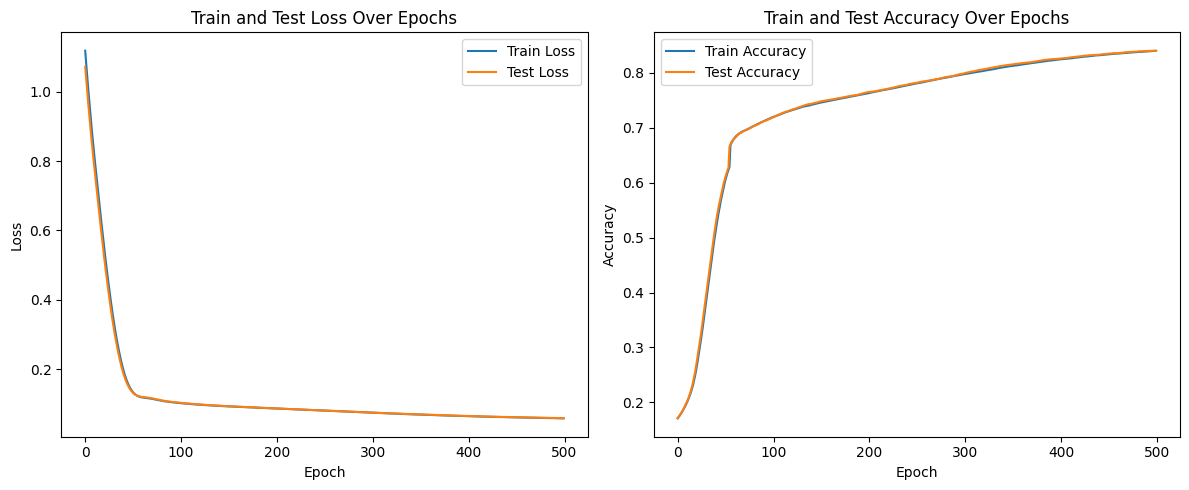

In [ ]:
# Plot train and test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss Over Epochs')
plt.legend()

# Plot train and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### Feeding the machine with a feed rate larger than 3300 can cause damage to the machinery; therefore, the limit for the feed rate is 3300.

In [ ]:
count_greater_than_3000 = data[data['Conveyor Belt Feed Rate (t/h)'] > 3000].shape[0]
count_greater_than_3300 = data[data['Conveyor Belt Feed Rate (t/h)'] > 3300].shape[0]
print('count_greater_than_3000',count_greater_than_3000)
print('count_greater_than_3300',count_greater_than_3300)

count_greater_than_3000 9857
count_greater_than_3300 58


# Optimization

## a) Objective function

In [ ]:
def inferencing(X): # (X_test_tensor, x_mean, x_std, y_std, y_mean, model)
  x_n = (X - x_mean) / x_std
  x_n_t = torch.tensor(x_n, dtype=torch.float32)
  #print('x_n_t', x_n_t)
  model.eval()
  with torch.inference_mode():
    y_preds = model(x_n_t)
    y_p_original = y_preds.detach().numpy()  * y_std + y_mean
    print('y_p_original', y_p_original)
  return y_p_original

In [ ]:
def objective(X): # (X_test_tensor, x_mean, x_std, y_std, y_mean, model)
  x_n = (X - x_mean) / x_std
  x_n_t = torch.tensor(x_n, dtype=torch.float32)

  model.eval()
  with torch.inference_mode():
    y_preds = model(x_n_t)
    y_p_original = y_preds.detach().numpy()  * y_std + y_mean
  return  -X/y_p_original

In [ ]:
# Test
X = 3050, 1030
y_p = inferencing(X)
print(y_p)

y_p_original Power Draw (MW)    20.360113
dtype: float64
Power Draw (MW)    20.360113
dtype: float64


In [ ]:
X = 3050, 900
y_p = inferencing(X)
print(y_p)

y_p_original Power Draw (MW)    20.100813
dtype: float64
Power Draw (MW)    20.100813
dtype: float64


In [ ]:
ÇX = 3050, 1100
y_p = inferencing(X)
print(y_p)

y_p_original Power Draw (MW)    20.100813
dtype: float64
Power Draw (MW)    20.100813
dtype: float64


## Graph using the **NN and the objective function** to predict **y** (Power Draw (MW)) using **x** (Conveyor Belt Feed Rate (t/h), Dilution Flow Rate (m3/h)).